In [1]:
import os

os.chdir("../")

In [2]:
import torch
import triton
import torch.nn.functional as F
from kernel.dropconnect.DropConnect import triton_dropconnect
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
def dropconnect(x: torch.Tensor, weight: torch.Tensor, bias: torch.Tensor):
    weight = weight.T
    squeezeloc = x.dim()-1
    x = x.unsqueeze(squeezeloc)
    weight = torch.broadcast_to(weight, (*x.shape[0:-2], *weight.shape))
    weight = F.dropout(weight, 0.5, training=True) * 0.5
    mul = torch.matmul(x, weight).squeeze(squeezeloc)
    out = mul + bias.view([1]*squeezeloc + [-1])
    return out

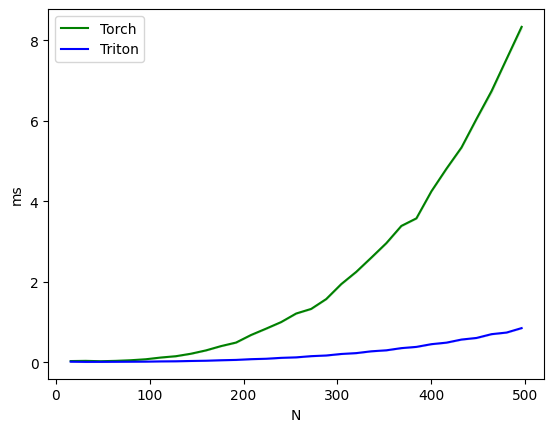

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["N","K","M"],  # Argument names to use as an x-axis for the plot
        x_vals=[16 * i for i in range(1, 32)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],  # Line color and style
        ylabel="ms",  # Label name for the y-axis
        plot_name="DropConnect-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))

@triton.testing.perf_report(configs)
def benchmark(N,K,M, provider):
    x = torch.randn((N, K), device='cuda', dtype=torch.float32, requires_grad=True)
    w = torch.randn((M, K), device='cuda', dtype=torch.float32, requires_grad=True)
    bias = torch.randn((M,), device='cuda', dtype=torch.float32, requires_grad=True)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: dropconnect(x=x, weight=w,bias=bias), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_dropconnect(x=x,w=w.T,bias=bias,tf32=torch.backends.cuda.matmul.allow_tf32), quantiles=quantiles)
    return ms, max_ms, min_ms

result = benchmark.run(show_plots=False, return_df=True)

[Text(0, 0.5, 'Time (ms)')]

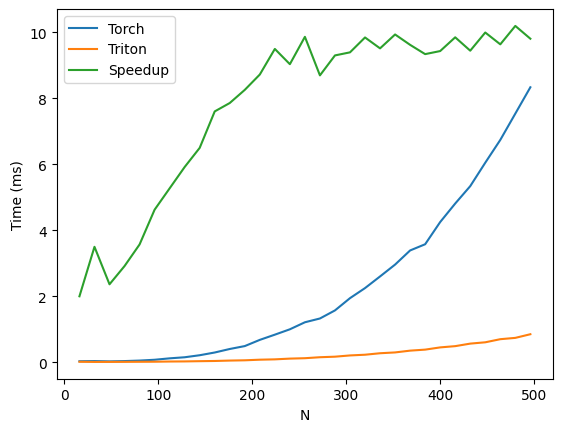

In [5]:
# convert list of dataframes to single dataframe
df = pd.concat(result)
df["ratio"]= df["Torch"] / df["Triton"]
ax1 = sns.lineplot(data=df, x="N", y="Torch", label="Torch")
sns.lineplot(data=df, x="N", y="Triton", ax=ax1,label="Triton")
sns.lineplot(data=df, x="N", y="ratio", ax=ax1,label="Speedup")
ax1.set(ylabel='Time (ms)')

In [6]:
from torch.profiler import profile, record_function, ProfilerActivity
device = 'cuda'

activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU]
M, K, N = 1024, 1024, 1024
x = torch.randn((M, K), device='cuda', dtype=torch.float32, requires_grad=True)
w = torch.randn((N, K), device='cuda', dtype=torch.float32, requires_grad=True)
bias = torch.randn((N,), device='cuda', dtype=torch.float32, requires_grad=True)
with profile(activities=activities) as prof:
    out = dropconnect(x=x, weight=w,bias=bias)
    # out.sum().backward()
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   aten::native_dropout         1.46%       1.994ms         1.82%       2.493ms       2.493ms     125.055ms        93.13%     125.064ms     125.064ms             1  
void at::native::(anonymous namespace)::fused_dropou...         0.00%       0.000us         0.00%       0.000us       0.000us     125.055ms        93.13%     125.055ms     125.055ms             1  
         

STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [7]:
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU]
with profile(activities=activities) as prof:
    out = dropconnect(x=x, weight=w,bias=bias)
prof.export_chrome_trace("trace/DropConnect/trace_torch.json")

STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [8]:
with profile(activities=activities) as prof:
    out = triton_dropconnect(x=x,w=w.T,bias=bias,tf32=torch.backends.cuda.matmul.allow_tf32)
    # out.sum().backward()

print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   _triton_dropconnect_         1.89%     170.000us        23.86%       2.152ms       2.152ms       6.932ms        99.91%       6.932ms       6.932ms             1  
                                 dropconnect_fwd_kernel         0.00%       0.000us         0.00%       0.000us       0.000us       6.932ms        99.91%       6.932ms       6.932ms             1  
         

STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [9]:
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU]
with profile(activities=activities) as prof:
    out = triton_dropconnect(x=x,w=w.T,bias=bias,tf32=torch.backends.cuda.matmul.allow_tf32)
prof.export_chrome_trace("trace/DropConnect/trace_triton.json")

STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-12-02 16:37:43 1074997:1074997 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
